In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from time import time

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from sklearn.metrics import silhouette_samples, silhouette_score,davies_bouldin_score
from sklearn.cluster import KMeans,DBSCAN
from sklearn.decomposition import PCA,IncrementalPCA,KernelPCA
from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler


from yellowbrick.cluster import KElbowVisualizer
from scipy.stats import mode

from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

In [2]:
# Read Data
data = pd.read_csv("../input/tabular-playground-series-jul-2022/data.csv",index_col='id')
submission = pd.read_csv("../input/tabular-playground-series-jul-2022/sample_submission.csv")

In [3]:
data.head()

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
id,,,,,,,,,,,,,,,,,,,,,
0,-0.389420,-0.912791,0.648951,0.589045,-0.830817,0.733624,2.258560,2,13,14,...,-0.478412,-0.757002,-0.763635,-1.090369,1.142641,-0.884274,1.137896,1.309073,1.463002,0.813527
1,-0.689249,-0.453954,0.654175,0.995248,-1.653020,0.863810,-0.090651,2,3,6,...,-0.428791,-0.089908,-1.784204,-0.839474,0.459685,1.759412,-0.275422,-0.852168,0.562457,-2.680541
2,0.809079,0.324568,-1.170602,-0.624491,0.105448,0.783948,1.988301,5,11,5,...,-0.413534,-1.602377,1.190984,3.267116,-0.088322,-2.168635,-0.974989,1.335763,-1.110655,-3.630723
3,-0.500923,0.229049,0.264109,0.231520,0.415012,-1.221269,0.138850,6,2,13,...,0.619283,1.287801,0.532837,1.036631,-2.041828,1.440490,-1.900191,-0.630771,-0.050641,0.238333
4,-0.671268,-1.039533,-0.270155,-1.830264,-0.290108,-1.852809,0.781898,8,7,5,...,-1.628830,-0.434948,0.322505,0.284326,-2.438365,1.473930,-1.044684,1.602686,-0.405263,-1.987263


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98000 entries, 0 to 97999
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f_00    98000 non-null  float64
 1   f_01    98000 non-null  float64
 2   f_02    98000 non-null  float64
 3   f_03    98000 non-null  float64
 4   f_04    98000 non-null  float64
 5   f_05    98000 non-null  float64
 6   f_06    98000 non-null  float64
 7   f_07    98000 non-null  int64  
 8   f_08    98000 non-null  int64  
 9   f_09    98000 non-null  int64  
 10  f_10    98000 non-null  int64  
 11  f_11    98000 non-null  int64  
 12  f_12    98000 non-null  int64  
 13  f_13    98000 non-null  int64  
 14  f_14    98000 non-null  float64
 15  f_15    98000 non-null  float64
 16  f_16    98000 non-null  float64
 17  f_17    98000 non-null  float64
 18  f_18    98000 non-null  float64
 19  f_19    98000 non-null  float64
 20  f_20    98000 non-null  float64
 21  f_21    98000 non-null  float64
 22

- NO missing values

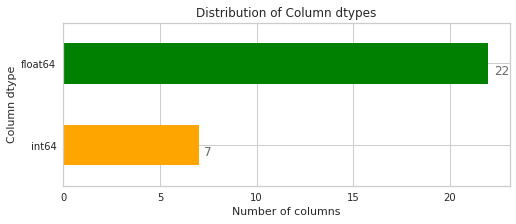

In [5]:

ax = data.dtypes.value_counts().plot.barh(color = ['green','orange'],rot = 0,figsize = (8,3))
ax.set_title('Distribution of Column dtypes')
ax.set_xlabel('Number of columns')
ax.set_ylabel('Column dtype')

for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, str(i.get_width()), fontsize=12,
color='dimgrey')
    
ax.invert_yaxis()

**Insight**
- There are only numeric feature
- There are 22 Continuous and 7 categorical variables

In [6]:
cat_cols = data.select_dtypes('int').columns
cont_cols = data.select_dtypes(exclude = 'int').columns

print(f'Categorical Variables: \n{cat_cols} \n\nContinuous Variables: \n{cont_cols}')

Categorical Variables: 
Index(['f_07', 'f_08', 'f_09', 'f_10', 'f_11', 'f_12', 'f_13'], dtype='object') 

Continuous Variables: 
Index(['f_00', 'f_01', 'f_02', 'f_03', 'f_04', 'f_05', 'f_06', 'f_14', 'f_15',
       'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24',
       'f_25', 'f_26', 'f_27', 'f_28'],
      dtype='object')


In [7]:
data[cont_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
f_00,98000.0,0.001220,1.002801,-4.732235,-0.675226,0.002022,0.677271,4.490521
f_01,98000.0,0.005580,1.000742,-4.202795,-0.670985,0.006650,0.677746,4.324974
f_02,98000.0,-0.001042,1.001373,-4.377021,-0.672779,-0.000324,0.677086,4.560247
f_03,98000.0,-0.000700,1.000422,-4.010826,-0.672540,-0.003185,0.672097,4.399373
f_04,98000.0,-0.003522,1.003061,-4.535903,-0.682510,-0.003307,0.677589,4.050549
f_05,98000.0,-0.001612,1.000532,-4.300767,-0.675066,0.001024,0.673344,4.710316
f_06,98000.0,-0.003042,0.997434,-4.894525,-0.680421,-0.002053,0.668112,3.998595
f_14,98000.0,0.003413,0.998940,-4.377021,-0.671810,0.003536,0.678679,4.490521
f_15,98000.0,-0.002639,1.001096,-4.535903,-0.677757,-0.004299,0.673859,4.270708
f_16,98000.0,0.005404,1.003277,-4.182233,-0.671055,0.006535,0.680903,4.157538


In [8]:
data[cat_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
f_07,98000.0,5.545918,3.691840,0.0,3.0,5.0,8.0,32.0
f_08,98000.0,6.763061,4.152348,0.0,4.0,6.0,9.0,30.0
f_09,98000.0,8.193163,5.904919,0.0,4.0,7.0,11.0,44.0
f_10,98000.0,8.057878,4.700226,0.0,5.0,7.0,11.0,36.0
f_11,98000.0,8.084990,4.197106,0.0,5.0,8.0,11.0,28.0
f_12,98000.0,7.076388,4.433308,0.0,4.0,6.0,10.0,38.0
f_13,98000.0,6.286102,4.120077,0.0,3.0,6.0,9.0,30.0


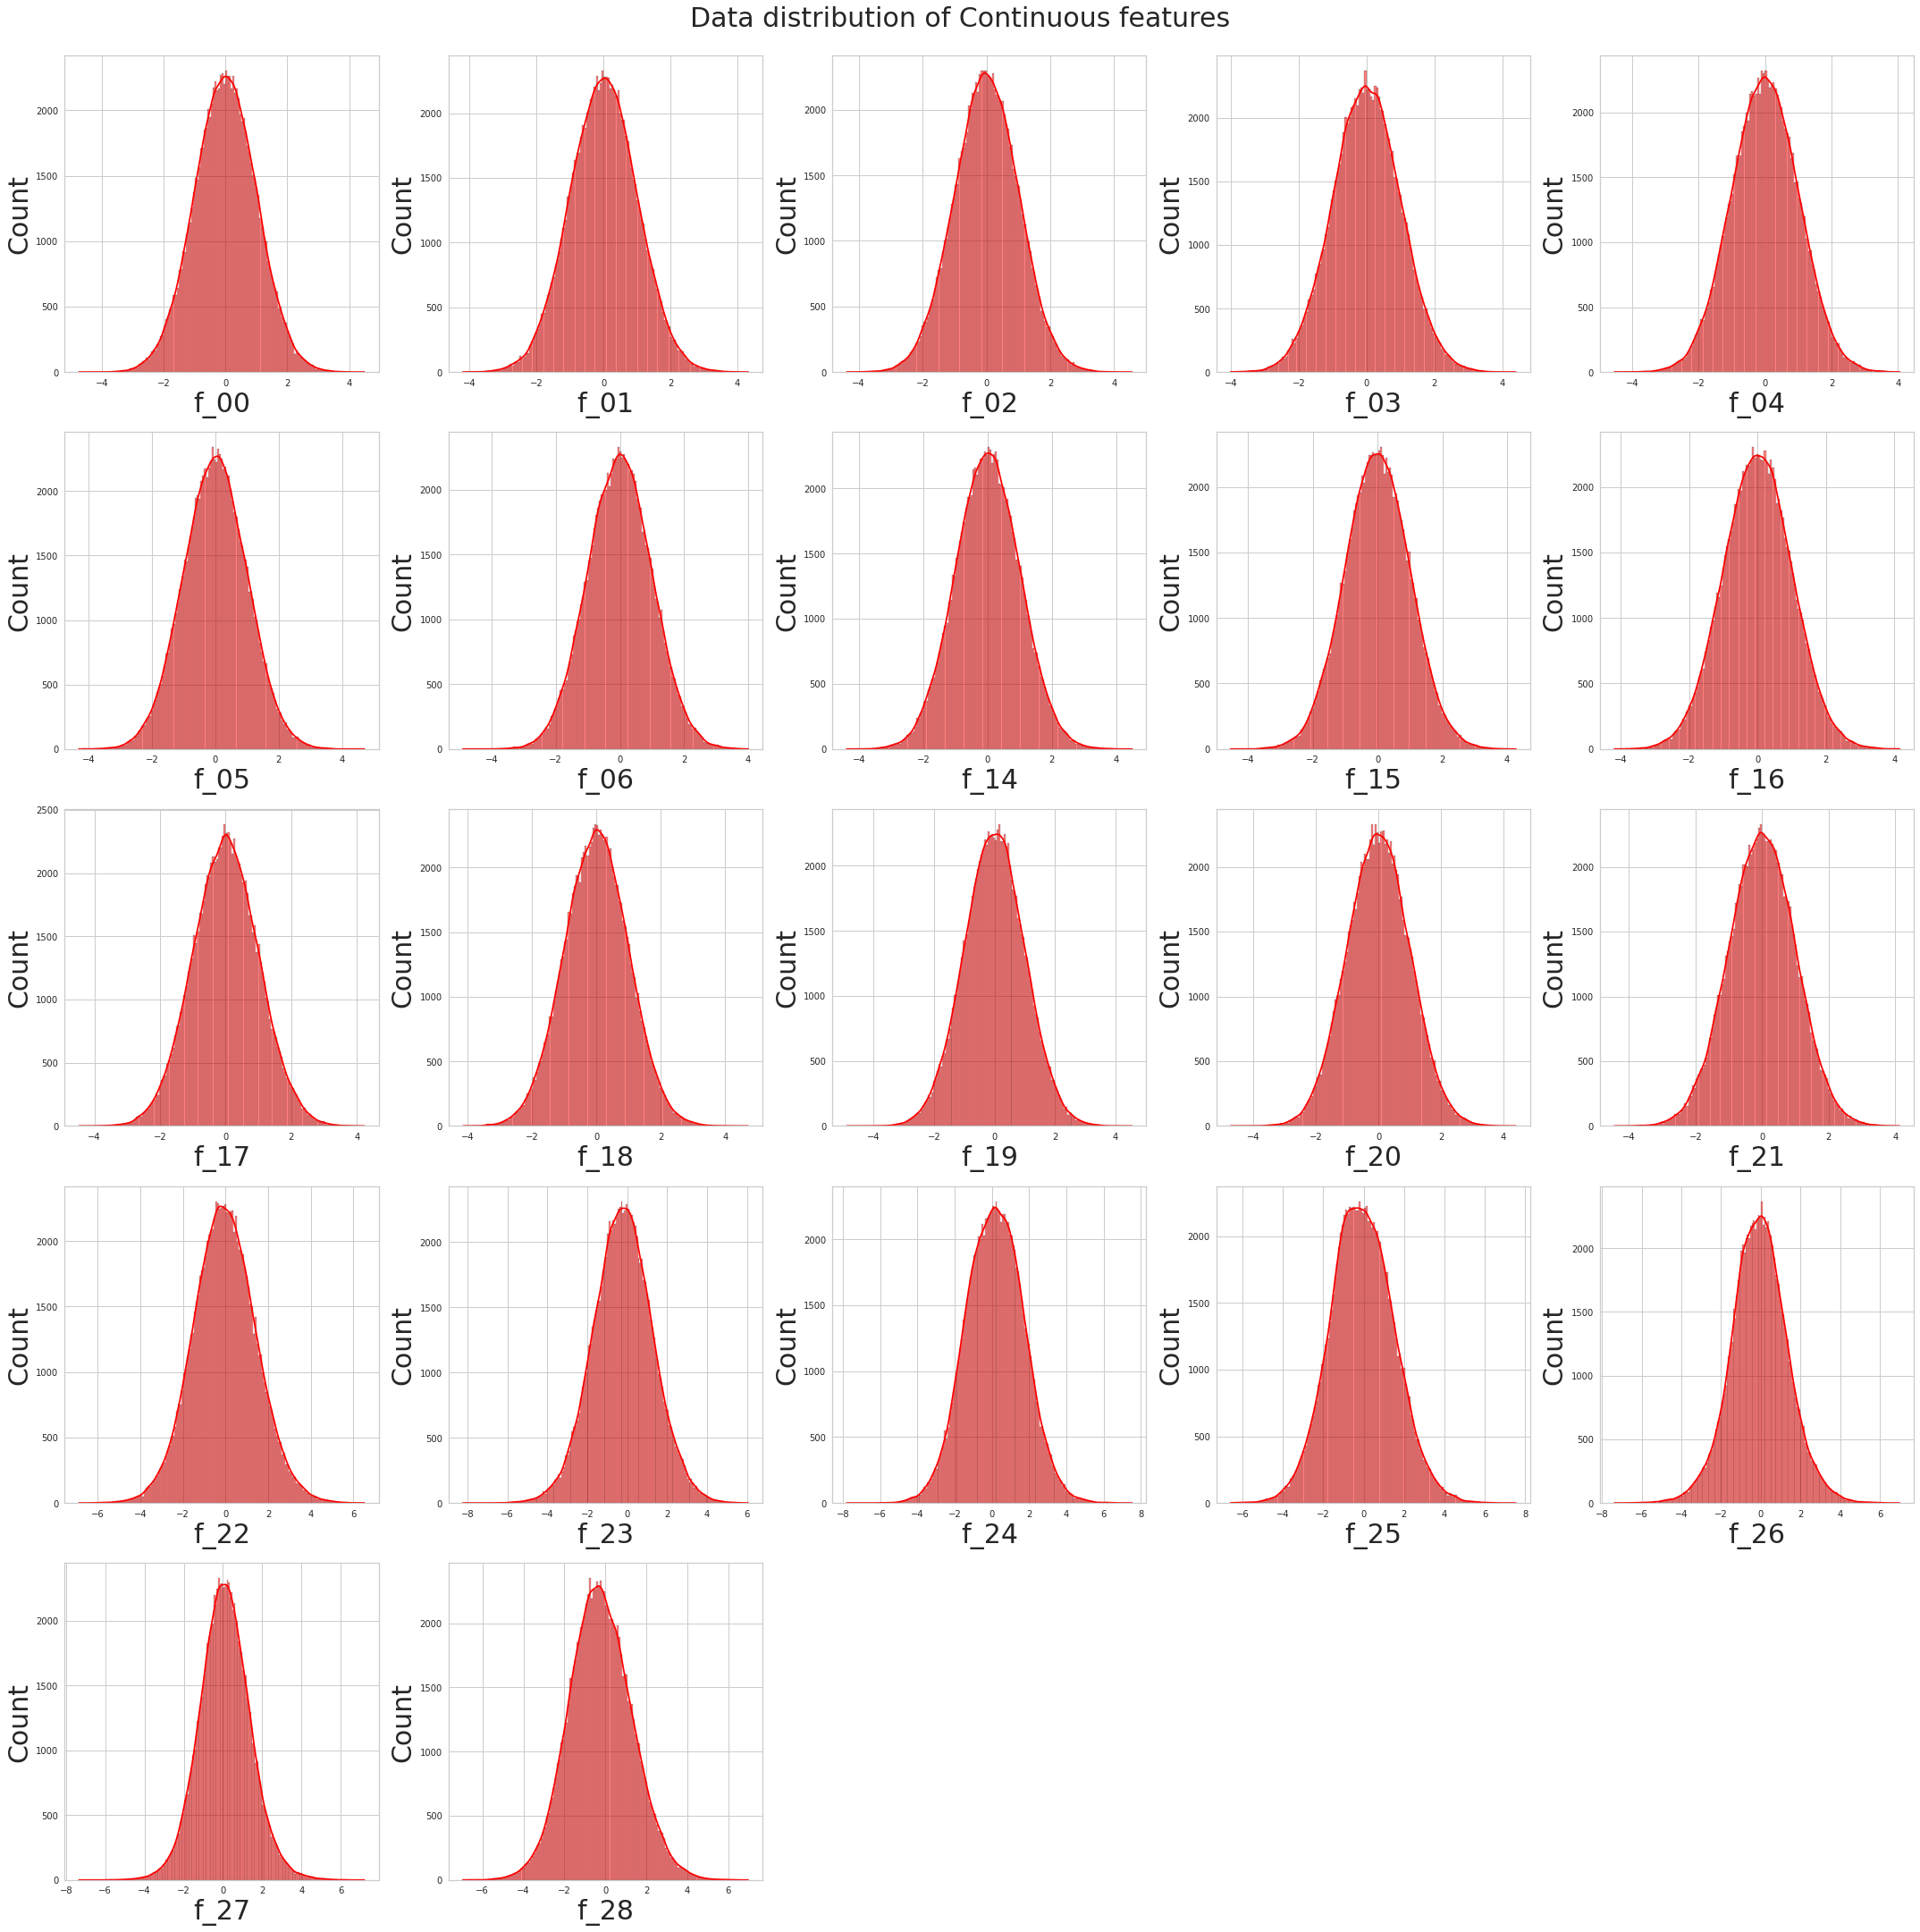

In [9]:
plt.figure(figsize=(30, 30))
for i, col in enumerate(cont_cols):
    ax = plt.subplot(int(np.ceil(len(cont_cols)/5)),int(np.ceil(len(cont_cols)/5)),i+1)
    b = sns.histplot(data = data, ax= ax, x=col, kde = True, color = 'red')
    ax.set_xlabel(b.get_xlabel(),size = 30)
    ax.set_ylabel(b.get_ylabel(),size = 30)

plt.suptitle('Data distribution of Continuous features',y = 1,fontsize = 30)
plt.tight_layout()
plt.show()

- While the mean and STD are close to 0 and 1, the data ranges almost equally on both sides

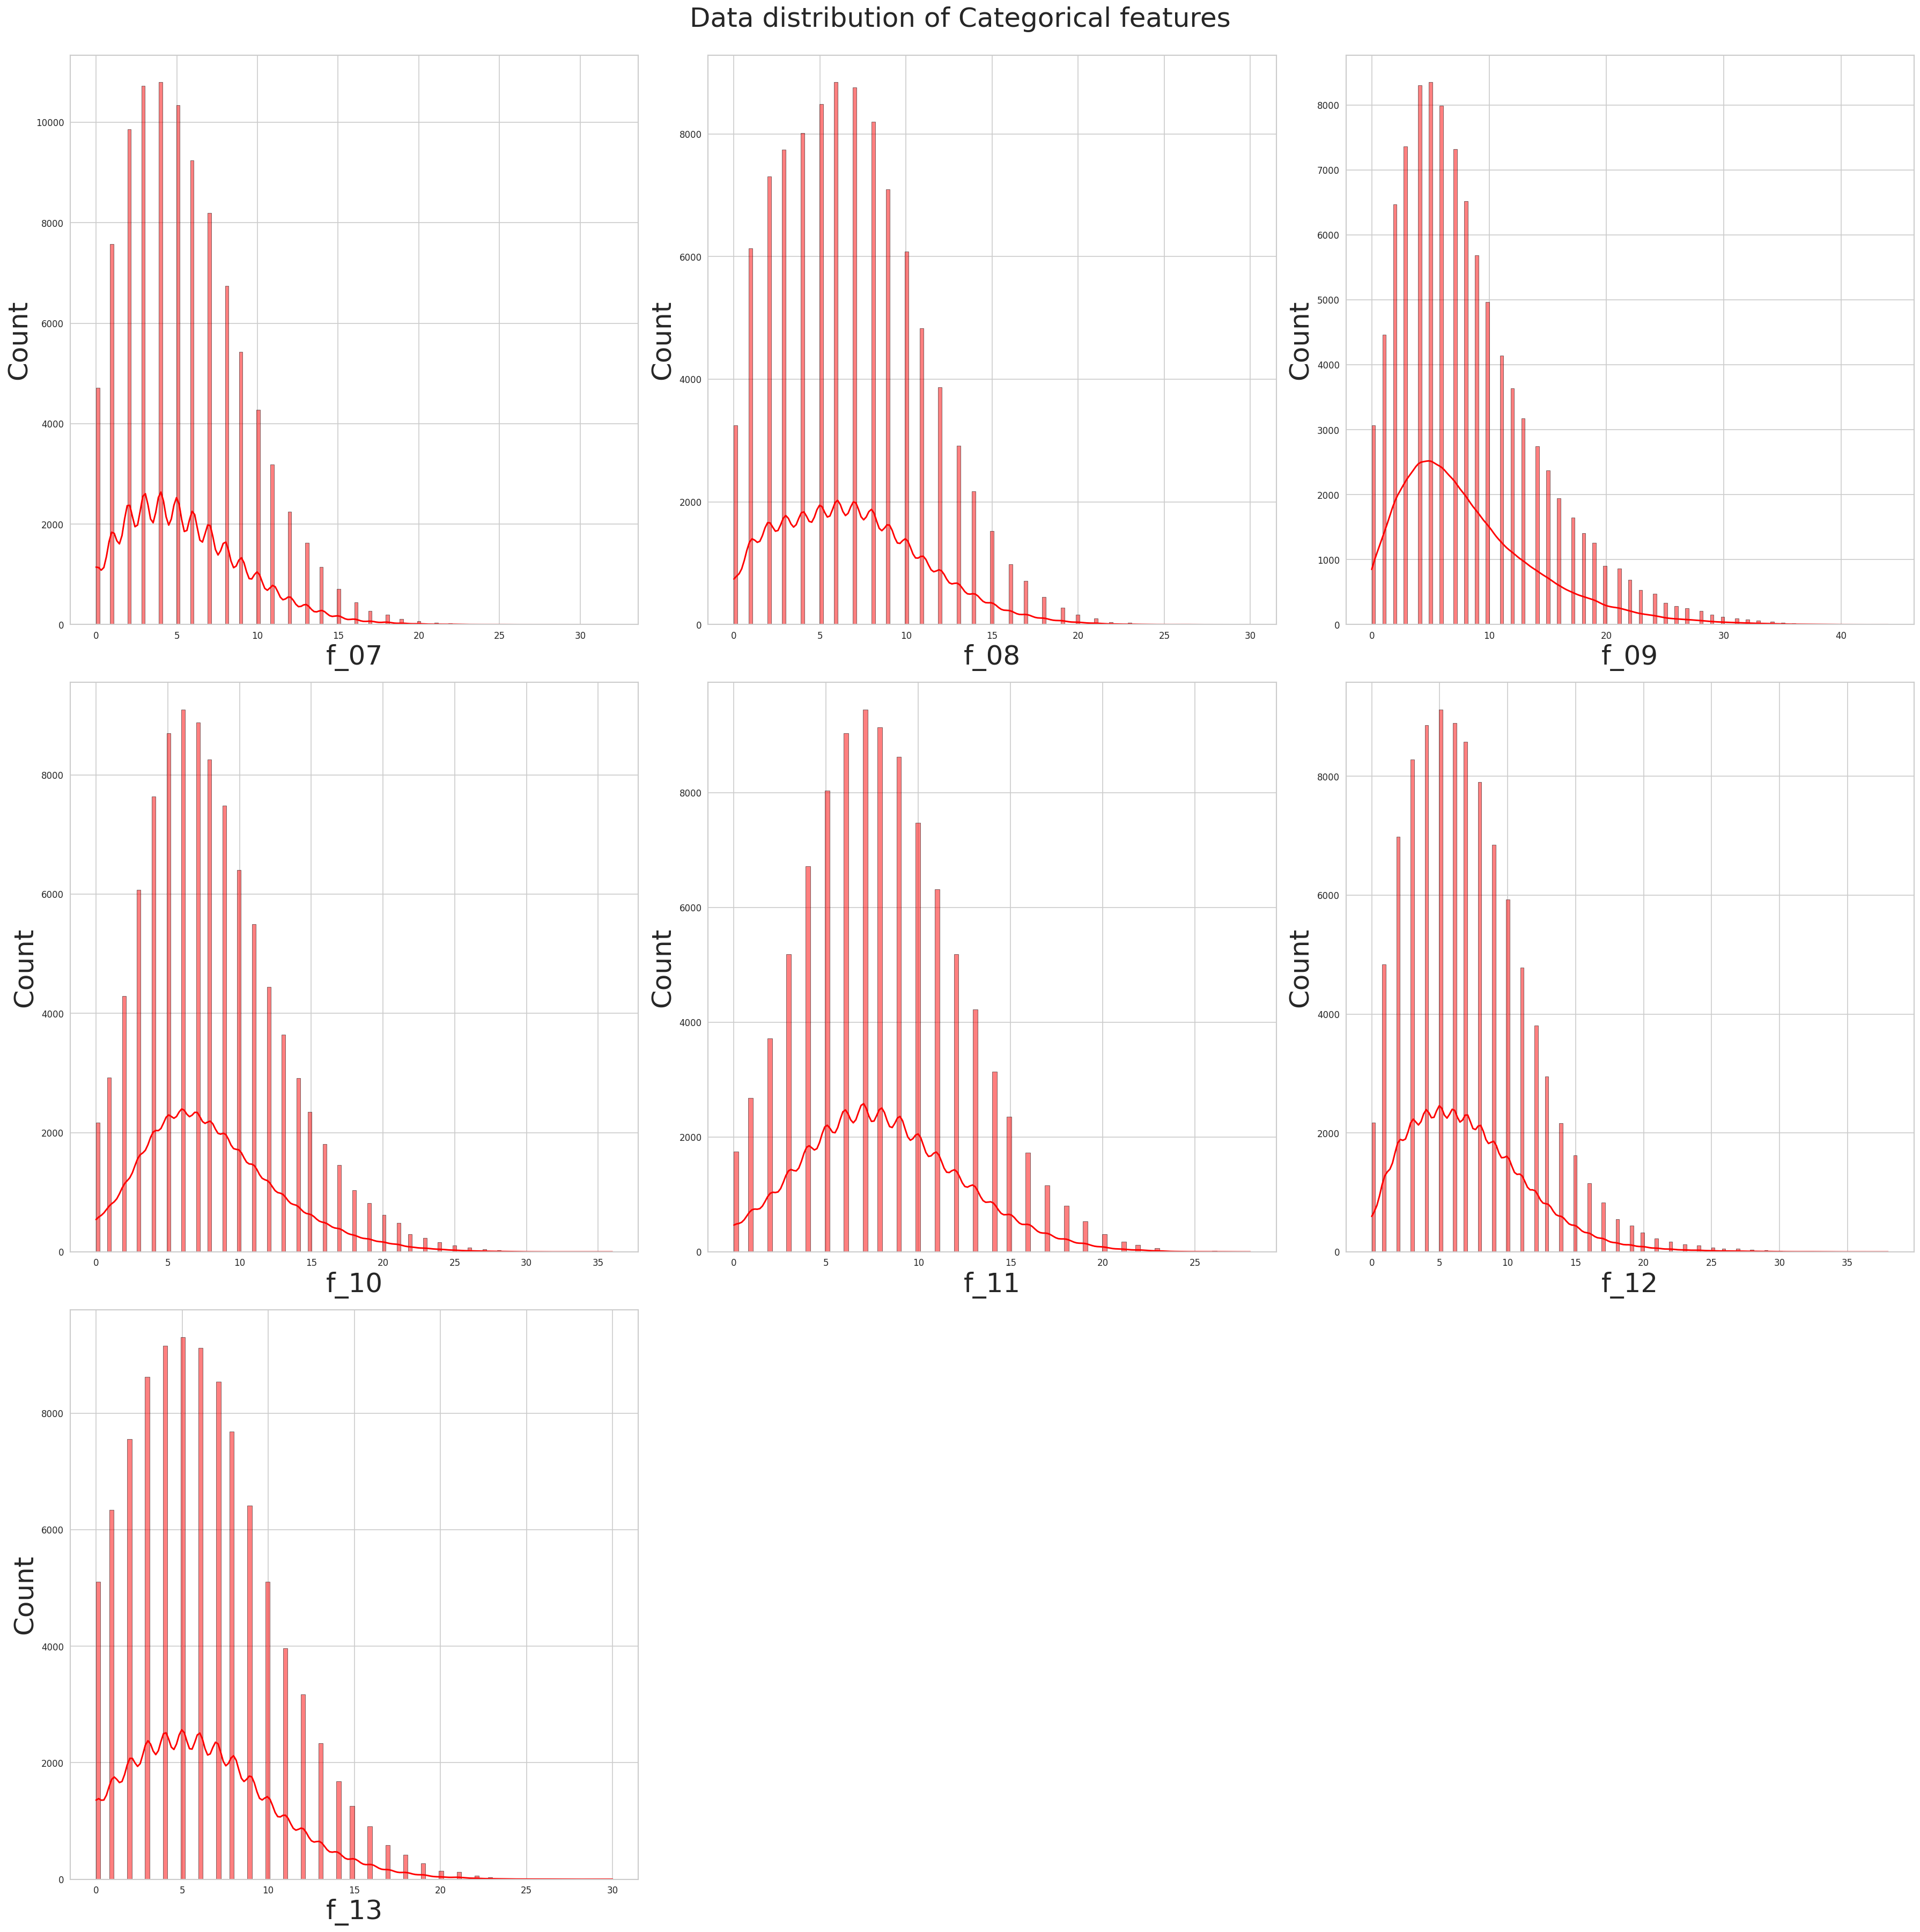

In [10]:
plt.figure(figsize=(30, 30),dpi= 120)
for i, col in enumerate(cat_cols):
    ax = plt.subplot(int(len(cat_cols)/2),int(len(cat_cols)/2),i+1)
    b = sns.histplot(data = data, ax= ax, x=col, kde = True, color = 'red')
    ax.set_xlabel(b.get_xlabel(),size = 30)
    ax.set_ylabel(b.get_ylabel(),size = 30)

plt.suptitle('Data distribution of Categorical features',y = 1,fontsize = 30)
plt.tight_layout()
plt.show()

**Insight**
- The data is left skewed
- There might be outliers

In [11]:
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

In [12]:
# Number of cluster centers for KMeans and BisectingKMeans
random_state =42
elbow_values = []
cluster_labels = []

### Finding right component size for PCA

In [13]:
pca= PCA()
pca.fit(data)

PCA()

#### Lets check the Variance - Component tradeoff for PCA

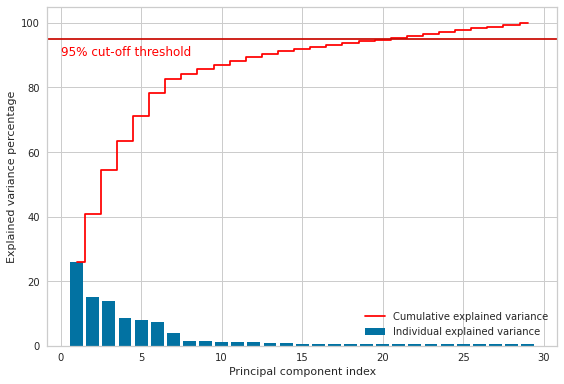

In [14]:
exp_var = pca.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)

plt.bar(range(1, 30), exp_var, align='center',
        label='Individual explained variance')

plt.step(range(1, 30), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='red')

plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
plt.axhline(y=95, color='r', linestyle='-')
plt.text(0,90, '95% cut-off threshold', color = 'red', fontsize=12)
plt.legend(loc='best')
ax.grid(axis='x')
plt.tight_layout()
plt.show()

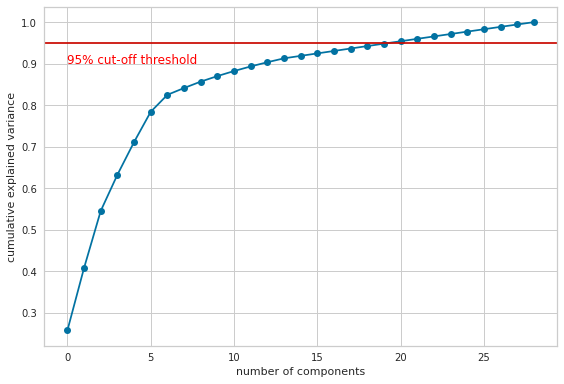

In [15]:
plt.plot(np.cumsum(pca.explained_variance_ratio_),marker='o')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0,0.90, '95% cut-off threshold', color = 'red', fontsize=12)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
ax.grid(axis='x')
plt.tight_layout()
plt.show()

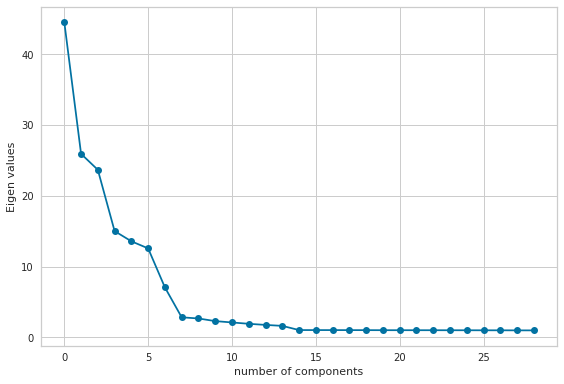

In [16]:
plt.plot(pca.explained_variance_,marker='o')
plt.xlabel('number of components')
plt.ylabel('Eigen values')
plt.tight_layout()
plt.show()

### Fit and Transform data based on identified component size

In [17]:
pca= PCA(n_components = 0.97,random_state = random_state)
data_scaled_pca = pca.fit_transform(data_scaled)

In [18]:
# Using non-PCA transformed dataset as it yielded better results
X = data_scaled_pca
X.shape

(98000, 28)

### Find Cluster size

In [19]:
clusterer = KMeans(random_state=random_state)

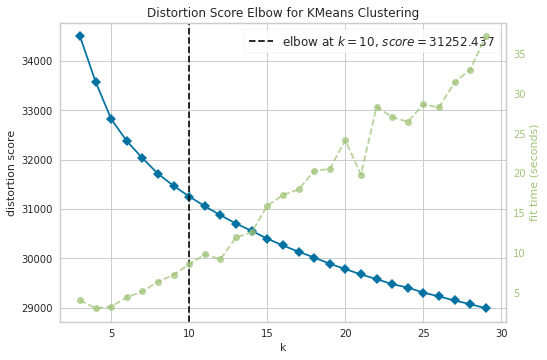

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [20]:
# Distortion Score for K means

visualizer = KElbowVisualizer(clusterer, k=(3,30), timings= True)
visualizer.fit(X)
elbow_values.append(visualizer.elbow_value_)
visualizer.show()

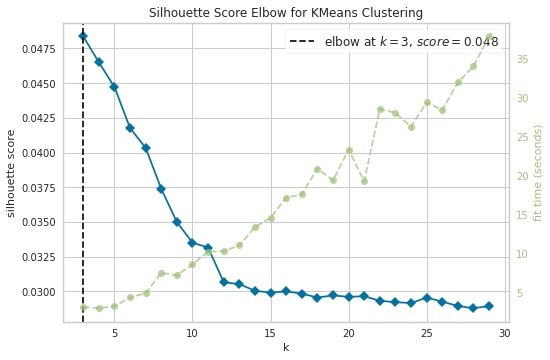

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [21]:
# Silhouette Score for K means

visualizer = KElbowVisualizer(clusterer, k=(3,30),metric='silhouette', timings= True)
visualizer.fit(X)
elbow_values.append(visualizer.elbow_value_)
visualizer.show()

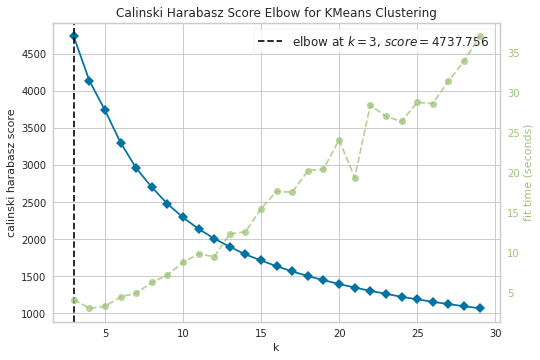

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [22]:
# Calinski Harabasz Score for K means

visualizer = KElbowVisualizer(clusterer, k=(3,30),metric='calinski_harabasz', timings= True)
visualizer.fit(X)
elbow_values.append(visualizer.elbow_value_)
visualizer.show()

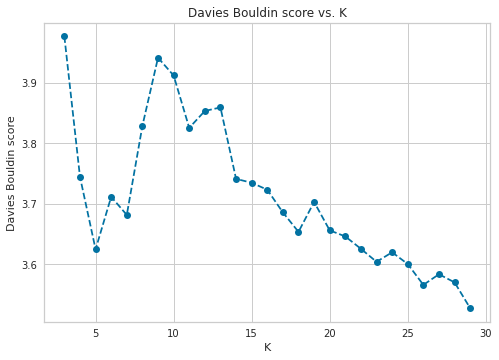

In [23]:
# Davies bouldin score for Kmeans

def get_kmeans_score(data, center):
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center,random_state = 42)
    # Then fit the model to your data using the fit method
    labels = kmeans.fit_predict(data)
    
    # Calculate Davies Bouldin score
    score = davies_bouldin_score(data, labels)
    
    return score


scores = []
centers = list(range(3,30))
for center in centers:
    scores.append(get_kmeans_score(X, center))

center_scores = dict(zip(centers,scores))
elbow_values.append(min(center_scores, key=center_scores.get))
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Davies Bouldin score');
plt.title('Davies Bouldin score vs. K');
plt.show()

### Fitting Gaussian Mixture

In [24]:
n_components = np.maximum(int(np.ceil(np.mean(elbow_values))),7)

# Fit Gaussian Mixture
print('Fitting Gaussian Mixture..')
gm = GaussianMixture(n_components = n_components,
                         max_iter = 1000, n_init = 10, 
                     random_state = random_state
                     )

gm_labels = gm.fit_predict(X)
cluster_labels.append(gm_labels)

# Fit Kmeans
print('Fitting Bayesian Gaussian Mixture..')
bgm = BayesianGaussianMixture(n_components = n_components,
               n_init =10,
               max_iter = 1000,
               random_state = random_state)

bgm_labels = bgm.fit_predict(X)
cluster_labels.append(bgm_labels)

Fitting Gaussian Mixture..
Fitting Bayesian Gaussian Mixture..


### Submission

In [25]:
submission['Predicted'] = mode(np.column_stack(cluster_labels),axis = 1)[0]
submission.to_csv('submission.csv',index=False)
submission

,Id,Predicted
0,0,0
1,1,3
2,2,10
3,3,2
4,4,1
...,...,...
97995,97995,3
97996,97996,1
97997,97997,6
97998,97998,7


<AxesSubplot:>

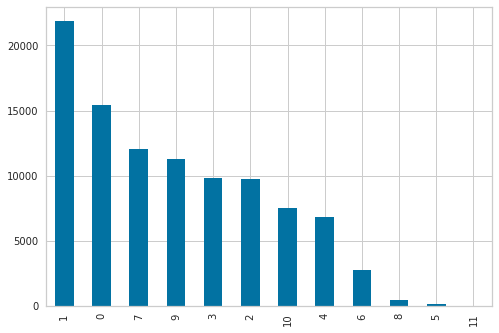

In [26]:
submission.Predicted.value_counts().plot.bar()

Future thoughts:
- Compare model performace of multiple clustering methods
- Experiement based on other clustering methods (maybe try ensemble scoring)
- Study each feature manually
- Reading few papers for clustering and implement benchmark